In [1]:
#@title
#Take input from user for prediction type
print("Select an option:")
print("1. Predict Electricity Consumption for 1 day")
print("2. Predict Electricity Consumption for 1 hour")
option = input("\nEnter your value: ") 

global text
if option==str(1):
  interval=48   #Next one day
  text='Number of 30 mins intervals in a day'
elif option==str(2):
  interval=2    #Next one hour
  text='Next 1 hour'
else: print("Wrong option entered.")

train_days=290
tot_intervals=train_days*interval

models=[]
errors={"Home B - 2014":[], "Home C - 2015":[], "Home F - 2016":[]}

Select an option:
1. Predict Electricity Consumption for 1 day
2. Predict Electricity Consumption for 1 hour

Enter your value: 1


In [2]:
import pandas as pd
#Format file for HomeB
epochTime=1388534400
df = pd.read_csv('data/Home B - 2014/HomeB-meter1_2014.csv')
wf = pd.read_csv('data/Home B - 2014/homeB2014.csv')
weather= list(wf['temperature'])
usage = list(df['use [kW]'][:16704])
tstamp=[]
temp=[]

for i in range(len(usage)):
  ts=pd.to_datetime(epochTime,unit='s')
  tstamp.append(ts)
  epochTime+=1800
  k=int(i/2) 
  temp.append(weather[k])
  
homeB = pd.Series(usage, name = 'load_demand[kW]')
homeB = pd.DataFrame(homeB)
homeB['time_stamp']=tstamp
homeB['temper']=temp

In [3]:
#Format file for HomeC
epochTime=1420070400
df = pd.read_csv('data/Home C -2015/HomeC-meter1_2015.csv')
wf = pd.read_csv('data/Home C -2015/homeC2015.csv')
weather= list(wf['temperature'])
usage = list(df['use [kW]'][0:16704])
tstamp=[]
temp=[]

for i in range(len(usage)):
  ts=pd.to_datetime(epochTime,unit='s')
  tstamp.append(ts)
  epochTime+=1800
  k=int(i/2) 
  temp.append(weather[k])

homeC = pd.Series(usage, name = 'load_demand[kW]')
homeC = pd.DataFrame(homeC)
homeC['time_stamp']=tstamp
homeC['temper']=temp

In [4]:
#Format file for HomeF
epochTime=1451606400
df = pd.read_csv('data/Home F - 2016/HomeF-meter3_2016.csv')
wf = pd.read_csv('data/Home F - 2016/homeF2016.csv')
weather= list(wf['temperature'])
usage = list(df['Usage [kW]'][:501091])
half_hour=[]
tstamp=[]
temp=[]

for i in range(0,len(usage),30):
  tot=sum(usage[i:i+30])/30
  ts=pd.to_datetime(epochTime,unit='s')
  tstamp.append(ts)
  epochTime+=1800 
  half_hour.append(tot)

for i in range(len(half_hour)):
  k=int(i/2)
  temp.append(weather[k])

homeF = pd.Series(half_hour, name = 'load_demand[kW]')
homeF = pd.DataFrame(homeF)
homeF['time_stamp']=tstamp
homeF['temper']=temp

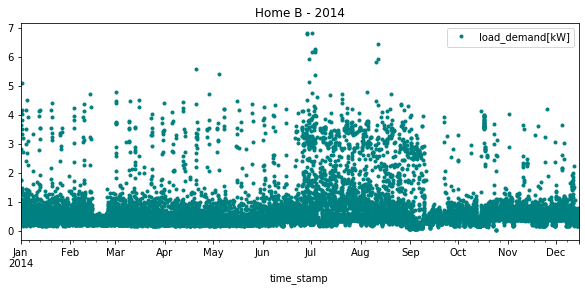

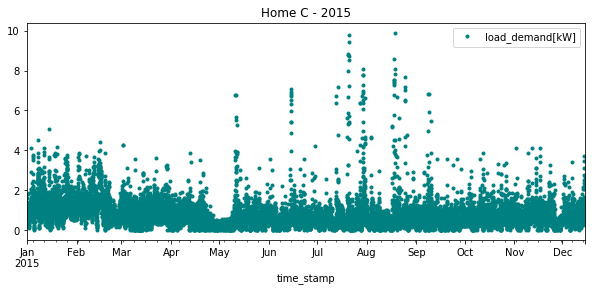

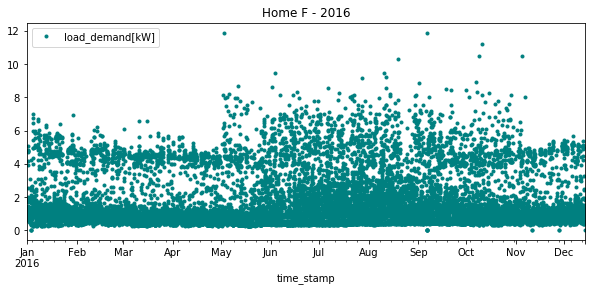

In [5]:
tot_data=[homeB,homeC,homeF]
homeB.plot('time_stamp','load_demand[kW]', style='.',title='Home B - 2014',figsize=(10,4), color='teal')
homeC.plot('time_stamp','load_demand[kW]', style='.',title='Home C - 2015' ,figsize=(10,4), color='teal')
homeF.plot('time_stamp','load_demand[kW]', style='.',title='Home F - 2016',figsize=(10,4), color='teal')

In [6]:
#Add new columns to data

import datetime
from pandas.tseries.holiday import USFederalHolidayCalendar

cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2014-01-01', end='2016-12-31').to_pydatetime()

for home in tot_data:
  # 1. Create a new column day from date
  def getDay(x):
      return x.day
  home['day'] = home['time_stamp'].map(getDay)

  # 2. Create a new column month from date
  def getMonth(x):
      return x.month
  home['month'] = home['time_stamp'].map(getMonth)

  # 3. Create a new column year from date
  def getYear(x):
      return x.year
  home['year'] = home['time_stamp'].map(getYear)

  # 4. Create a new column hour from date
  def getHour(x):
      return x.hour
  home['hour'] = home['time_stamp'].map(getHour)

  # 5. Create a new column hour from date
  def getWeekDay(x):
      return x.weekday()
  home['weekday'] = home['time_stamp'].map(getWeekDay)

  #6. Create a new column to check holiday or not
  def check_holiday(row_data):
    strip_date = datetime.datetime.strptime((str(row_data.time_stamp)[:10] ),'%Y-%m-%d')
    return 1 if strip_date in holidays else 0
  home['holiday'] = home.apply(lambda row: check_holiday(row), axis=1)

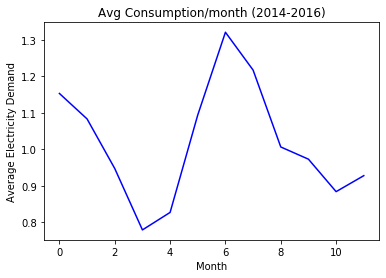

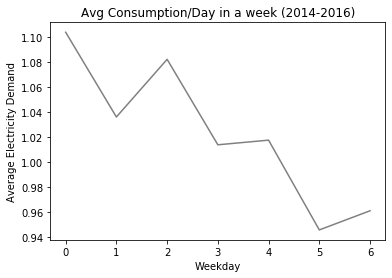

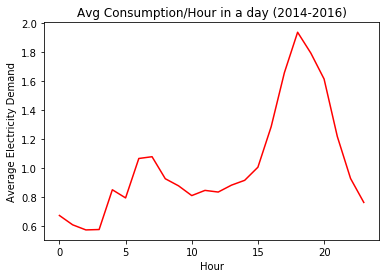

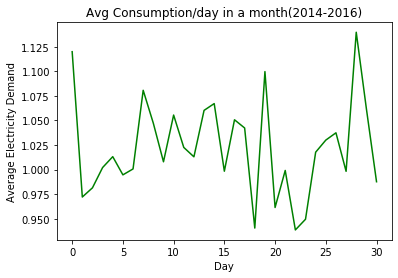

In [7]:
#Create Data Aggregate Plots over the 3 years 2014-2016

import matplotlib.pyplot as plt

data = pd.DataFrame()
data = pd.concat(tot_data, ignore_index=True)

groupby_month = data.groupby(['month']).mean()
plt.plot(list(groupby_month['load_demand[kW]']) , color='blue')
plt.title(label='Avg Consumption/month (2014-2016)')
plt.xlabel('Month')
plt.ylabel('Average Electricity Demand')
plt.show()

groupby_weekday = data.groupby(['weekday']).mean()
plt.plot(list(groupby_weekday['load_demand[kW]']), color='gray')
plt.title(label='Avg Consumption/Day in a week (2014-2016)')
plt.xlabel('Weekday')
plt.ylabel('Average Electricity Demand')
plt.show()

groupby_hour = data.groupby(['hour']).mean()
plt.plot(list(groupby_hour['load_demand[kW]']), color='red')
plt.title(label='Avg Consumption/Hour in a day (2014-2016)')
plt.xlabel('Hour')
plt.ylabel('Average Electricity Demand')
plt.show()

groupby_day = data.groupby(['day']).mean()
plt.plot(list(groupby_day['load_demand[kW]']), color='green')
plt.title(label='Avg Consumption/day in a month(2014-2016)')
plt.xlabel('Day')
plt.ylabel('Average Electricity Demand')
plt.show()


In [8]:
#Plotting function for all the models

def plotvalues(x, y1, y2, n, model1, model2):
    
    if len(y1)==2:
        act=round((sum(y1)/2),4)
        pred=round((sum(y2)/2),4)
        graph=pd.DataFrame({'Actual': [act], 'Predicted': [pred]})
        bars=graph.plot(kind='bar', width=0.2, title=n)
        plt.xlabel(text)
        plt.ylabel('Power Consumption in kWh')
        plt.tick_params(axis='x', bottom=False, labelbottom=False)
        plt.show()
    
    else:
        plt.title(n)
        plt.xlabel(text)
        plt.ylabel('Power Consumption in kWh')
        plt.plot(x, y1,'g', label=model1)
        plt.plot(x, y2,'y', label=model2)
        plt.legend(loc='upper left')
        plt.show()


In [9]:
homeB

,load_demand[kW],time_stamp,temper,day,month,year,hour,weekday,holiday
0,0.304439,2014-01-01 00:00:00,20.31,1,1,2014,0,2,1
1,0.656771,2014-01-01 00:30:00,20.31,1,1,2014,0,2,1
2,0.612895,2014-01-01 01:00:00,19.22,1,1,2014,1,2,1
3,0.683979,2014-01-01 01:30:00,19.22,1,1,2014,1,2,1
4,0.197809,2014-01-01 02:00:00,18.10,1,1,2014,2,2,1
...,...,...,...,...,...,...,...,...,...
16699,0.660155,2014-12-14 21:30:00,35.81,14,12,2014,21,6,0
16700,0.391376,2014-12-14 22:00:00,35.86,14,12,2014,22,6,0
16701,0.532069,2014-12-14 22:30:00,35.86,14,12,2014,22,6,0
16702,0.433086,2014-12-14 23:00:00,35.68,14,12,2014,23,6,0


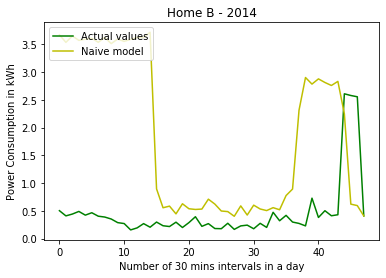

Mean_Absolute_Error for prediction using Naive model: 1.59022


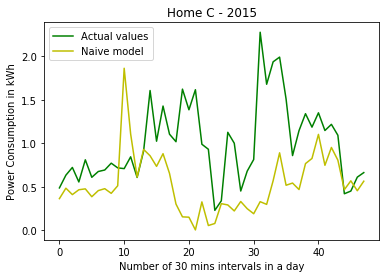

Mean_Absolute_Error for prediction using Naive model: 0.53233


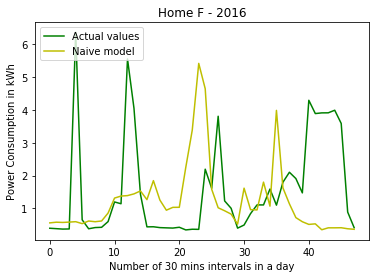

Mean_Absolute_Error for prediction using Naive model: 1.36774


In [10]:
#Naive model
import numpy as np
models.append("Naive Model")

def Naive_Model(X):
    return X[-interval:]

def Mean_Absolute_Error(x, y):
    return sum([abs(x[i] - y[i]) for i in range(len(y))])/(len(y))

k = 1
for house_data in tot_data:
    column = house_data.columns[0]
    if k==1 : n='Home B - 2014'
    elif k==2: n='Home C - 2015'
    else: n='Home F - 2016'
    X_range = np.array([i for i in range(interval)])
    X_train = np.array(house_data[column].values[:tot_intervals])
    Y_actual = np.array(house_data[column].values[tot_intervals:tot_intervals+interval])
    Y_predicted_naive_model = np.array(Naive_Model(X_train))
    err=Mean_Absolute_Error(Y_actual, Y_predicted_naive_model)
    plotvalues(X_range, Y_actual, Y_predicted_naive_model, n, "Actual values", "Naive model")
    print("Mean_Absolute_Error for prediction using Naive model: %.5f" % err)
    errors[n].append(round(err,5))
    k += 1

Mean Absolute Error : 0.44918


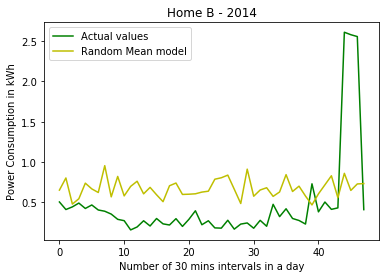

Mean Absolute Error : 0.36769


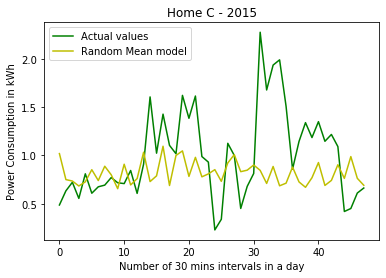

Mean Absolute Error : 1.23965


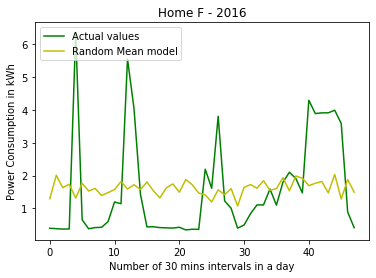

In [11]:
#Random Mean
import random

models.append("Random Mean")

def random_mean(house_data,n):
    train_Y = np.array(house_data[column].values[:tot_intervals])
    mean_test_Y = np.array((house_data[column].values[tot_intervals:tot_intervals+interval]))
    mean_predicted_Y=[]

    for i in range(len(mean_test_Y)):
      mean_train_Y=[]
      for j in range(interval):
        mean_train_Y.append(random.choice(train_Y))
      mean_predicted_Y.append(sum(mean_train_Y)/interval)
    err=Mean_Absolute_Error(mean_test_Y, mean_predicted_Y)
    print("Mean Absolute Error : %.5f" % err)
    errors[n].append(round(err,5))
    return mean_predicted_Y
    
k = 1
for house_data in tot_data:
    column = house_data.columns[0]
    if k==1 : n='Home B - 2014'
    elif k==2: n='Home C - 2015'
    else: n='Home F - 2016'
    Y_predicted = random_mean(house_data,n)
    X_range = np.array([i for i in range(interval)])
    Y_actual = np.array(house_data[column].values[tot_intervals:tot_intervals+interval])
    plotvalues(X_range, Y_actual, Y_predicted, n, "Actual values", "Random Mean model")
    k += 1

Mean Absolute Error : 0.47853


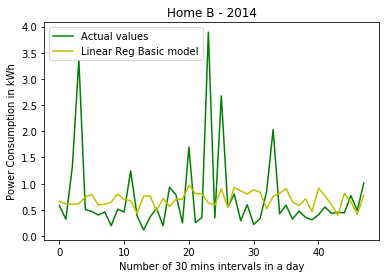

Mean Absolute Error : 0.43976


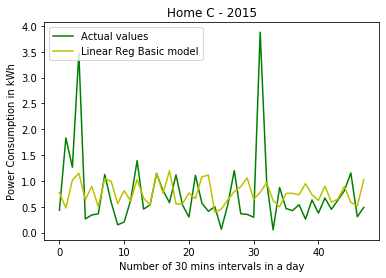

Mean Absolute Error : 1.14081


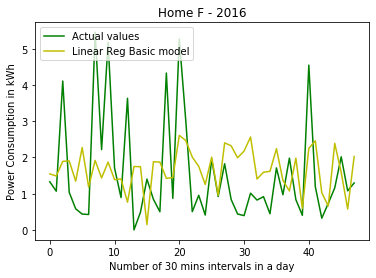

In [12]:
#Linear Regression

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
models.append("Linear Regression")

k = 1
for house_data in tot_data:
    home = house_data.drop(['time_stamp'], axis = 1)
    columns = home.columns
    
    X_train_lin, X_test_lin, y_train_lin, y_test_lin = train_test_split(home[columns[1:]],\
                                                        home[columns[0]], train_size=16656, random_state=0)

    regressor = LinearRegression()  
    regressor.fit(X_train_lin, y_train_lin)
    y_pred = regressor.predict(X_test_lin)
    
    err=Mean_Absolute_Error(list(y_test_lin), list(y_pred))
    print("Mean Absolute Error : %.5f" % err)
    errors[n].append(round(err,5))
    
    if k==1 : n='Home B - 2014'
    elif k==2: n='Home C - 2015'
    else: n='Home F - 2016'
    
    X_range = np.array([i for i in range(interval)])
    plotvalues(X_range, y_test_lin[:interval], y_pred[:interval], n, "Actual values", "Linear Reg Basic model")
    k += 1

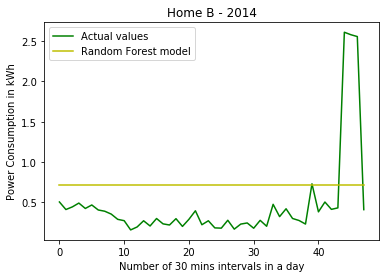

Mean Absolute Error : 0.47969


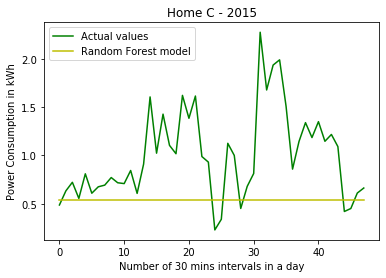

Mean Absolute Error : 0.49466


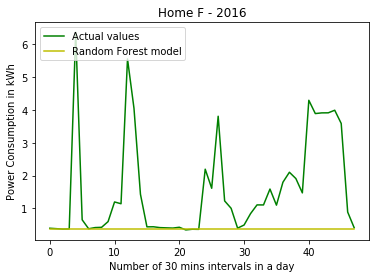

Mean Absolute Error : 1.20841


In [13]:
#Random Forest
from sklearn.ensemble import RandomForestRegressor as RF
models.append('RANDOM FOREST')

rand_forest_reg = RF(random_state=0, n_jobs = -1, n_estimators = 30, oob_score = True)
k = 1
for home in tot_data:
    if k==1 : n='Home B - 2014'
    elif k==2: n='Home C - 2015'
    else: n='Home F - 2016'
    column = home.columns[0]

    X = home[column].values[tot_intervals:tot_intervals+interval]
    X_train = np.array([i for i in range(1,len(X_train)+1)]).reshape(-1, 1)
    Y_train = np.array(home[column].values[:tot_intervals])
    X_test = np.array([len(X_train)+i for i in range(1,len(X)+1)]).reshape(-1, 1)
    Y_test = np.array((home[column].values[tot_intervals:tot_intervals+interval]))
    X_range = np.array([i for i in range(interval)])
    
    rand_forest_reg.fit (X_train, Y_train)
    Y_pred_rf = rand_forest_reg.predict(X_test)
    plotvalues(X_range, Y_test, Y_pred_rf, n, "Actual values", "Random Forest model")
    err=Mean_Absolute_Error(Y_pred_rf, Y_test)
    print ("Mean Absolute Error : %.5f" % err)
    errors[n].append(round(err,5))
    k += 1

Mean Absolute Error : 0.43044


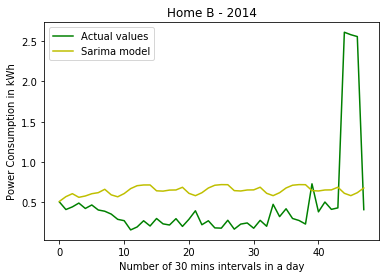

Mean Absolute Error : 0.43514


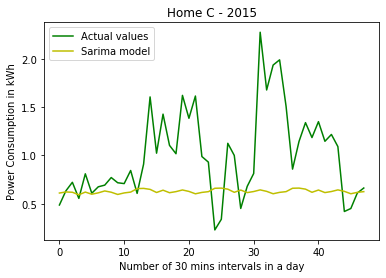

Mean Absolute Error : 1.21992


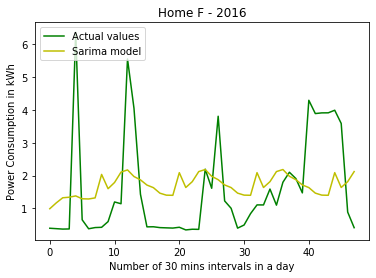

In [14]:
#Sarima Model
import warnings
import itertools
import statsmodels.api as sm

from statsmodels.tsa.statespace.sarimax import SARIMAX
from random import random

models.append('SARIMA')
def sarima_model(house_data,n):
    column = house_data.columns[0]
    X_train = np.array(house_data[column].values[:tot_intervals])
    
    p = d = q = range(0, 2)

    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    
    #model = SARIMAX(X_train, order=(0, 1, 0), seasonal_order=(1, 1, 1, 12))
    model = SARIMAX(X_train, order=(1, 0, 0), seasonal_order=(0, 1, 1, 12))
    model_fit = model.fit(disp=False)
    predicted_Y = model_fit.predict(len(X_train), len(X_train)+interval-1)
    X_test = house_data[column].values[tot_intervals:tot_intervals+interval]
    err=Mean_Absolute_Error(X_test, predicted_Y)
    print("Mean Absolute Error : %.5f" % err)
    errors[n].append(round(err,5))
    return predicted_Y

k = 1
for house_data in tot_data:
    if k==1 : n='Home B - 2014'
    elif k==2: n='Home C - 2015'
    else: n='Home F - 2016'
    sarima_model_out = sarima_model(house_data,n)
    column = house_data.columns[0]
    X_range = np.array([i for i in range(interval)])
    Y_actual = np.array(house_data[column].values[tot_intervals:tot_intervals+interval])
    plotvalues(X_range, Y_actual, sarima_model_out, n, "Actual values", "Sarima model")
    k += 1

Importing plotly failed. Interactive plots will not work.


Mean Absolute Error : 1.39702


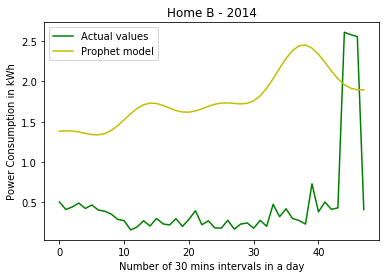

Mean Absolute Error : 0.34112


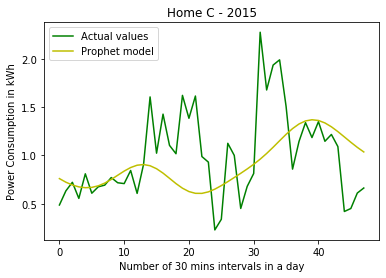

Mean Absolute Error : 1.10706


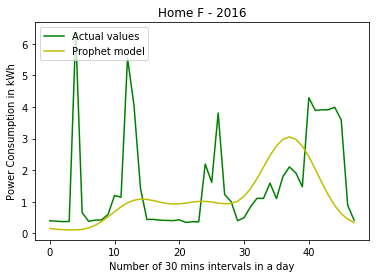

In [15]:
#Prophet Model
from fbprophet import Prophet

models.append('Prophet Model')
def prophet_model(house_data,n):
    df = pd.DataFrame({"ds":house_data["time_stamp"].values})
    df['y'] = house_data['load_demand[kW]']
    df.reset_index(drop=False,inplace=True)

    fp_train_X = df[:tot_intervals]
    fp_train_Y = np.array(df['y'].values[:tot_intervals])
    fp_test_X = df[tot_intervals:tot_intervals+interval]
    fp_test_Y = np.array(df['y'].values[tot_intervals:tot_intervals+interval])

    # creating holiday list
    fed_holiday = pd.DataFrame({"ds":house_data["time_stamp"].values})
    fed_holiday['holiday'] = house_data['holiday']
    fed_holiday = fed_holiday[fed_holiday['holiday'] == 1]
    fed_holiday['holiday'] = fed_holiday.apply(lambda row: 'holiday', axis=1)

    m = Prophet(yearly_seasonality=True, holidays=fed_holiday)
    m.fit(fp_train_X)

    future = m.make_future_dataframe(periods=60*24, freq='min')
    future = future[::-30][:interval]
    future = future[::-1]
   
    result_y = m.predict(future)
    err=Mean_Absolute_Error(fp_test_Y, result_y['yhat'])
    print("Mean Absolute Error : %.5f" % err)
    errors[n].append(round(err,5))
    return result_y['yhat']

k = 1
for house_data in tot_data:
    column = house_data.columns[0]
    if k==1 : n='Home B - 2014'
    elif k==2: n='Home C - 2015'
    else: n='Home F - 2016'
    Y_predicted_prophet_model = prophet_model(house_data,n)
    X_range = np.array([i for i in range(interval)])
    #X_train = np.array(house_data[column].values[:tot_intervals])
    Y_actual = np.array(house_data[column].values[tot_intervals:tot_intervals+interval])
    plotvalues(X_range, Y_actual, Y_predicted_prophet_model, n, "Actual values", "Prophet model")
    k += 1

In [16]:
errors

{'Home B - 2014': [1.59022, 0.44918, 0.43976, 0.47969, 0.43044, 1.39702],
 'Home C - 2015': [0.53233, 0.36769, 1.14081, 0.49466, 0.43514, 0.34112],
 'Home F - 2016': [1.36774, 1.23965, 0.47853, 1.20841, 1.21992, 1.10706]}

In [17]:
#Create report compilation
report=pd.DataFrame({
    'Models':models,
    'HomeB-2014(MAE)': errors['Home B - 2014'],
    'HomeC-2015(MAE)': errors['Home C - 2015'],
    'HomeF-2016(MAE)': errors['Home F - 2016']
    },index=range(1,len(models)+1,1))


# **Results**


---



In [18]:
report

,Models,HomeB-2014(MAE),HomeC-2015(MAE),HomeF-2016(MAE)
1,Naive Model,1.59022,0.53233,1.36774
2,Random Mean,0.44918,0.36769,1.23965
3,Linear Regression,0.43976,1.14081,0.47853
4,RANDOM FOREST,0.47969,0.49466,1.20841
5,SARIMA,0.43044,0.43514,1.21992
6,Prophet Model,1.39702,0.34112,1.10706


# 